# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

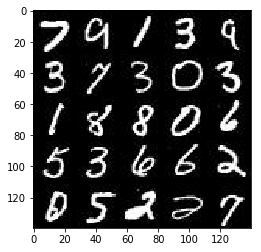

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

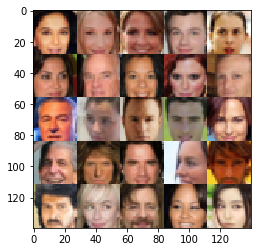

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.nn.dropout(x2, 0.8)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, 0.8)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.nn.dropout(x4, 0.8)
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 4x4x256
        
        # Flatten it
#         flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
#         x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
#         x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid',
#                                         kernel_initializer=tf.contrib.layers.xavier_initializer())      
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())  
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
#         print("x2:")
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    smooth_factor = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth_factor)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     if data_image_mode == "RGB":
#         out_channel_dim = 3
#     else:
#         out_channel_dim = 1
    _, image_width, image_height, out_channel_dim = data_shape

    steps = 0
    print_every=10
    show_every=100
    
    input_real, input_z, l_rate = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # The reason for doing so is that the generator returns values in the range [-1, 1], 
                # while the batch_images has values in the range [-0.5, 0.5]. 
                # So, we need normalize the batch_images to the range [-1, 1] 
                # as same as the returned values of the generator.
                batch_images = batch_images * 2 
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
#                 _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 5 * 5, input_z, out_channel_dim, data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6504... Generator Loss: 4.2263
Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 3.6578
Epoch 1/2... Discriminator Loss: 2.6115... Generator Loss: 0.1748
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 9.5104
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.9340
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 4.3813
Epoch 1/2... Discriminator Loss: 0.4042... Generator Loss: 3.5709
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 2.0591
Epoch 1/2... Discriminator Loss: 2.5066... Generator Loss: 0.2242
Epoch 1/2... Discriminator Loss: 0.3832... Generator Loss: 5.2383


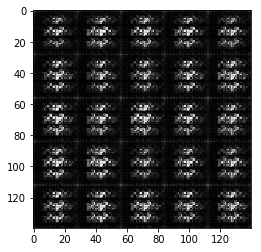

Epoch 1/2... Discriminator Loss: 0.5431... Generator Loss: 6.8244
Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 2.1989
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.2611
Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 3.8671
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 1.7019
Epoch 1/2... Discriminator Loss: 0.5113... Generator Loss: 5.4390
Epoch 1/2... Discriminator Loss: 0.4908... Generator Loss: 3.0141
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 3.7557
Epoch 1/2... Discriminator Loss: 0.4725... Generator Loss: 2.9044
Epoch 1/2... Discriminator Loss: 0.7235... Generator Loss: 5.6830


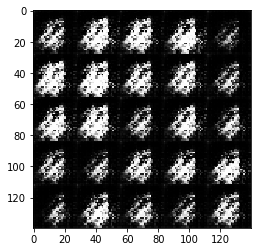

Epoch 1/2... Discriminator Loss: 0.4368... Generator Loss: 3.5309
Epoch 1/2... Discriminator Loss: 0.3682... Generator Loss: 4.8880
Epoch 1/2... Discriminator Loss: 0.3853... Generator Loss: 4.0893
Epoch 1/2... Discriminator Loss: 0.3817... Generator Loss: 3.7415
Epoch 1/2... Discriminator Loss: 2.3964... Generator Loss: 11.6159
Epoch 1/2... Discriminator Loss: 0.4450... Generator Loss: 3.6918
Epoch 1/2... Discriminator Loss: 0.4028... Generator Loss: 3.3034
Epoch 1/2... Discriminator Loss: 0.3835... Generator Loss: 3.6836
Epoch 1/2... Discriminator Loss: 0.3848... Generator Loss: 3.7977
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 3.2767


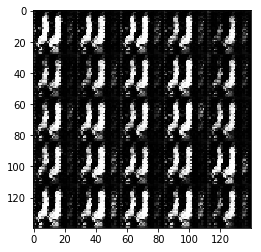

Epoch 1/2... Discriminator Loss: 0.3924... Generator Loss: 3.8416
Epoch 1/2... Discriminator Loss: 0.4270... Generator Loss: 3.3936
Epoch 1/2... Discriminator Loss: 0.3907... Generator Loss: 3.8310
Epoch 1/2... Discriminator Loss: 0.3570... Generator Loss: 5.5030
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 8.1049
Epoch 1/2... Discriminator Loss: 0.3930... Generator Loss: 5.1556
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 3.5153
Epoch 1/2... Discriminator Loss: 0.3861... Generator Loss: 3.9918
Epoch 1/2... Discriminator Loss: 0.3718... Generator Loss: 4.6053
Epoch 1/2... Discriminator Loss: 0.3608... Generator Loss: 4.6071


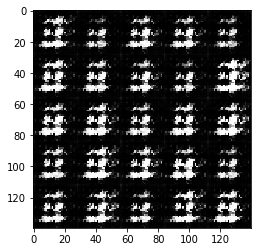

Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 2.7245
Epoch 1/2... Discriminator Loss: 0.3695... Generator Loss: 6.7361
Epoch 1/2... Discriminator Loss: 0.3722... Generator Loss: 5.0464
Epoch 1/2... Discriminator Loss: 0.3898... Generator Loss: 3.2334
Epoch 1/2... Discriminator Loss: 0.3724... Generator Loss: 5.5523
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 4.0037
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 4.1886
Epoch 1/2... Discriminator Loss: 0.4602... Generator Loss: 6.5993
Epoch 1/2... Discriminator Loss: 0.5729... Generator Loss: 1.8716
Epoch 1/2... Discriminator Loss: 0.5016... Generator Loss: 3.1581


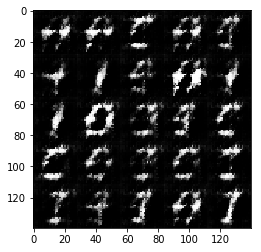

Epoch 1/2... Discriminator Loss: 0.5142... Generator Loss: 5.4134
Epoch 1/2... Discriminator Loss: 0.5194... Generator Loss: 2.2496
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 3.3876
Epoch 1/2... Discriminator Loss: 0.4257... Generator Loss: 3.5692
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 2.5700
Epoch 1/2... Discriminator Loss: 0.4232... Generator Loss: 3.0046
Epoch 1/2... Discriminator Loss: 0.5165... Generator Loss: 4.5204
Epoch 1/2... Discriminator Loss: 0.4620... Generator Loss: 3.1570
Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 2.3180
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 2.5255


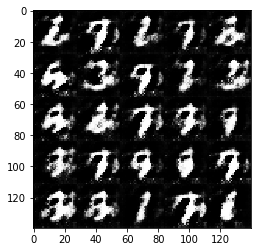

Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 2.2964
Epoch 1/2... Discriminator Loss: 0.5184... Generator Loss: 2.7466
Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 3.3591
Epoch 1/2... Discriminator Loss: 0.4444... Generator Loss: 3.9572
Epoch 1/2... Discriminator Loss: 0.7069... Generator Loss: 2.2441
Epoch 1/2... Discriminator Loss: 0.4043... Generator Loss: 3.2736
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.7778
Epoch 1/2... Discriminator Loss: 0.5630... Generator Loss: 2.3052
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 2.0651
Epoch 1/2... Discriminator Loss: 0.4407... Generator Loss: 2.7717


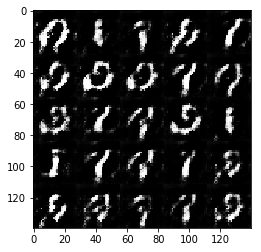

Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.9979
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 4.3276
Epoch 1/2... Discriminator Loss: 0.4161... Generator Loss: 3.5291
Epoch 1/2... Discriminator Loss: 0.4325... Generator Loss: 3.3010
Epoch 1/2... Discriminator Loss: 0.4072... Generator Loss: 3.4374
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 2.2136
Epoch 1/2... Discriminator Loss: 0.4235... Generator Loss: 3.7903
Epoch 1/2... Discriminator Loss: 0.5220... Generator Loss: 3.4366
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 4.7238


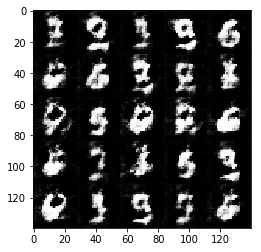

Epoch 1/2... Discriminator Loss: 0.4464... Generator Loss: 3.3484
Epoch 1/2... Discriminator Loss: 0.5275... Generator Loss: 2.2769
Epoch 1/2... Discriminator Loss: 0.5421... Generator Loss: 2.3460
Epoch 1/2... Discriminator Loss: 0.4815... Generator Loss: 3.6286
Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 1.0851
Epoch 1/2... Discriminator Loss: 0.5385... Generator Loss: 2.0600
Epoch 1/2... Discriminator Loss: 0.3724... Generator Loss: 5.7075
Epoch 1/2... Discriminator Loss: 0.5082... Generator Loss: 3.1069
Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 3.0880
Epoch 1/2... Discriminator Loss: 0.5095... Generator Loss: 2.1911


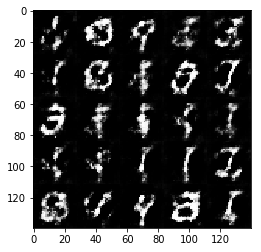

Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 1.8055
Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 4.7221
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 4.8955
Epoch 2/2... Discriminator Loss: 0.5100... Generator Loss: 2.9982
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 6.0692
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 2.8597
Epoch 2/2... Discriminator Loss: 0.4610... Generator Loss: 3.1739
Epoch 2/2... Discriminator Loss: 0.5176... Generator Loss: 2.0702
Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 2.6864


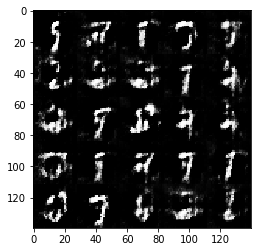

Epoch 2/2... Discriminator Loss: 0.4328... Generator Loss: 3.7714
Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 5.9576
Epoch 2/2... Discriminator Loss: 0.4174... Generator Loss: 3.8797
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 2.7389
Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 3.9896
Epoch 2/2... Discriminator Loss: 0.6826... Generator Loss: 1.4575
Epoch 2/2... Discriminator Loss: 1.7703... Generator Loss: 0.4623
Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 1.4274
Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 1.2224
Epoch 2/2... Discriminator Loss: 1.2108... Generator Loss: 0.7946


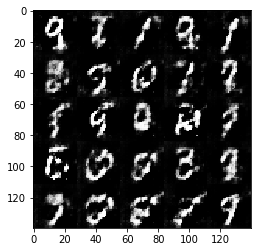

Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 3.6854
Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 2.2504
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 4.2681
Epoch 2/2... Discriminator Loss: 0.6350... Generator Loss: 1.8899
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 2.9367
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 1.1937
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 2.6966
Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 2.1108


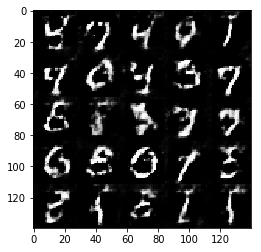

Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 4.3224
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.8701
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.7521
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 0.5358... Generator Loss: 2.2272
Epoch 2/2... Discriminator Loss: 1.0462... Generator Loss: 0.8568
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.9974
Epoch 2/2... Discriminator Loss: 1.6837... Generator Loss: 4.1115
Epoch 2/2... Discriminator Loss: 1.1619... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 2.5443


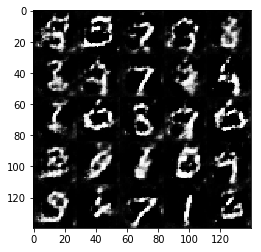

Epoch 2/2... Discriminator Loss: 2.1872... Generator Loss: 0.2718
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 2.4450
Epoch 2/2... Discriminator Loss: 0.8813... Generator Loss: 1.2265
Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 1.7180
Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 2.3306
Epoch 2/2... Discriminator Loss: 0.4886... Generator Loss: 2.7516
Epoch 2/2... Discriminator Loss: 0.7706... Generator Loss: 1.4380
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 0.6558... Generator Loss: 1.6101
Epoch 2/2... Discriminator Loss: 0.8450... Generator Loss: 1.1510


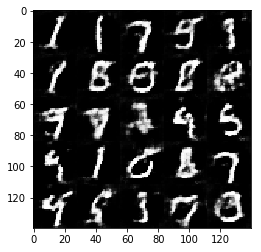

Epoch 2/2... Discriminator Loss: 0.5982... Generator Loss: 2.8257
Epoch 2/2... Discriminator Loss: 0.6039... Generator Loss: 2.1034
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.4345
Epoch 2/2... Discriminator Loss: 0.7607... Generator Loss: 1.3239
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 2.1251
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 1.7221
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.9719
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 2.2956


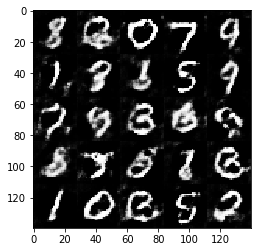

Epoch 2/2... Discriminator Loss: 0.8682... Generator Loss: 1.1833
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 2.9158
Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 2.0127
Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 1.2184
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.5546
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.6301
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 3.5371
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 2.3624
Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 1.8011
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.9257


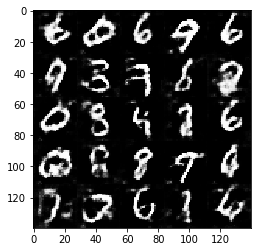

Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 2.4604
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 0.7094... Generator Loss: 1.3565
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 2.5642
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 3.8300
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 2.2598
Epoch 2/2... Discriminator Loss: 0.8498... Generator Loss: 2.2080
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.2074
Epoch 2/2... Discriminator Loss: 0.6190... Generator Loss: 2.7272


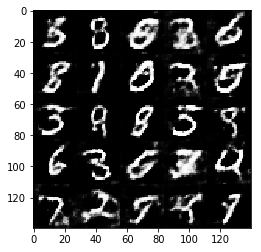

Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.8194
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 2.2289
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 0.6425... Generator Loss: 1.6760
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 2.8904
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.7682


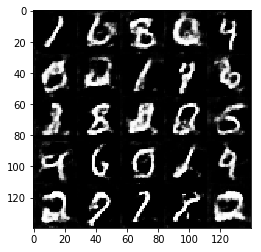

Epoch 2/2... Discriminator Loss: 0.6002... Generator Loss: 2.4305
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.5734
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 1.6046
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 0.7907... Generator Loss: 1.9464
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 1.0509


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [22]:
print("###############################################################################")
print("oye, training is done.")
print("###############################################################################")

###############################################################################
oye, training is done.
###############################################################################


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 7.4361
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.4285
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 3.3685
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 2.8927
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 3.5382
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 3.1869
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 2.7091


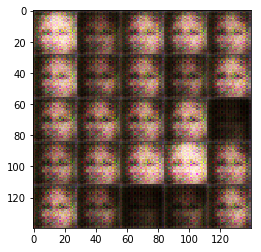

Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 2.1348
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 2.9859
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.3409
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 3.0998
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.6686
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 2.3277
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.8199
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 2.5540


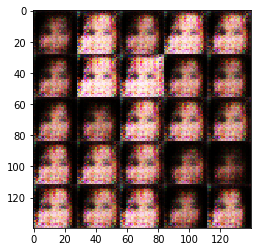

Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.8895
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.5877
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 3.1115
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 3.7200
Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 2.4071
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.7112
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 2.1301
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.8748
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.3099


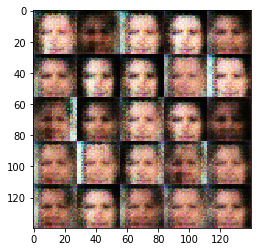

Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 3.6128
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 2.8463
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 2.2645
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 1.7122
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.1060
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.9134
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 2.0936


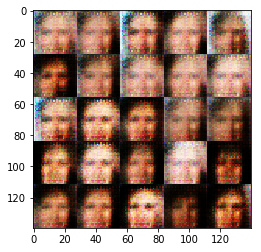

Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 3.5749
Epoch 1/1... Discriminator Loss: 1.7764... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 2.8944
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.4424
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 2.1963
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.6397


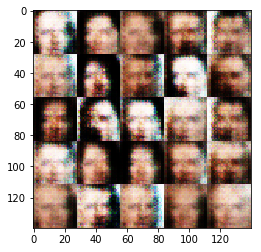

Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 3.6678
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 2.7229
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 2.1640
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.4212
Epoch 1/1... Discriminator Loss: 0.5801... Generator Loss: 2.4221
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.5561


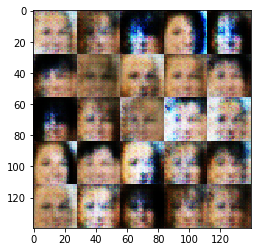

Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 2.1820
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 2.3726
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 2.1631
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 5.1152
Epoch 1/1... Discriminator Loss: 0.8511... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 3.3692


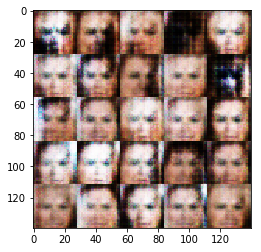

Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 3.3783
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.4062
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.9219
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.0237


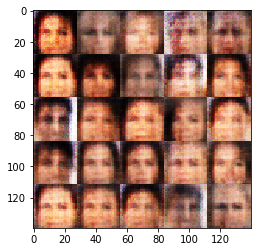

Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.2202
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.3556
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 2.1920
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.4391
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.8030
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 2.1416


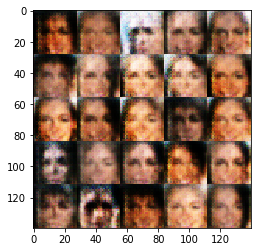

Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.9010
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.9502
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 2.7600
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.5904
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 2.3658
Epoch 1/1... Discriminator Loss: 0.7854... Generator Loss: 1.6981
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.1964


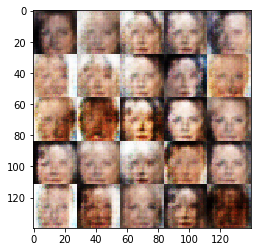

Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 2.2765
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.3085
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.7817
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 2.3624
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.9377


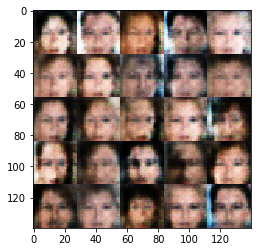

Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 2.3780
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 2.3337
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 2.6089
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.4779
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 2.2983
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 1.4560


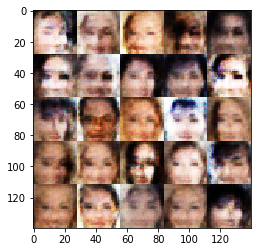

Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.6139
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.4389
Epoch 1/1... Discriminator Loss: 2.3526... Generator Loss: 4.6199
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.8895
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.5931


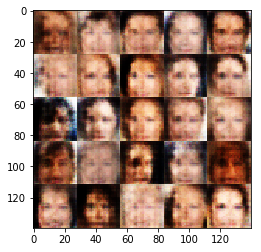

Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.8318
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 2.7053
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 2.8955
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.2702


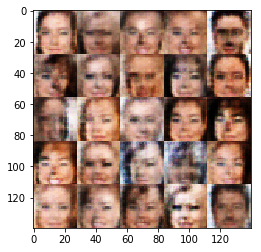

Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.7044
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 2.1265
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 2.5325
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.7311
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 2.5635
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.9196
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.5117


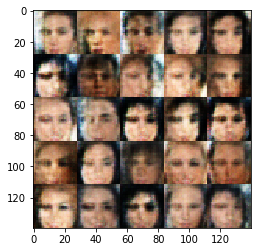

Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.9289
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 2.4904
Epoch 1/1... Discriminator Loss: 2.6691... Generator Loss: 6.6297
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 3.9356
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.3197


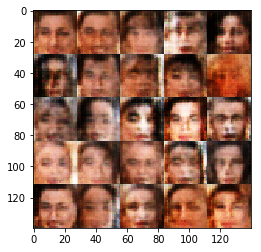

Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 2.9456
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.8514


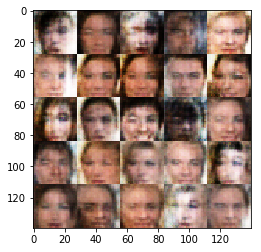

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.8664
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 2.5396
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 2.3201
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 2.0263


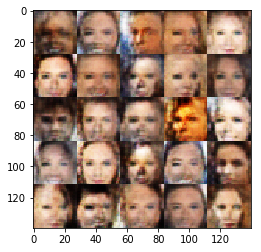

Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.8078
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.4546
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.8713
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.4293
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.6670


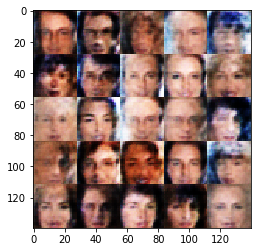

Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 1.7948
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.6489
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 3.0424
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.0316


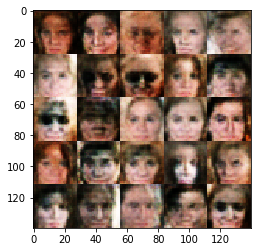

Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.7804
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 2.1846
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 2.1247
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 2.1986


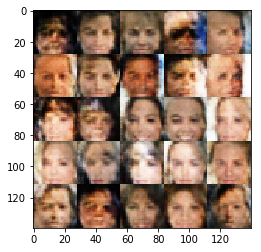

Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 3.0359
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 2.4554
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 0.9643... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.7942


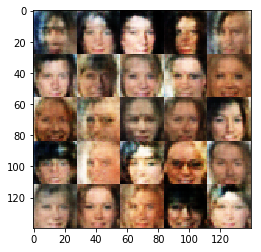

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 2.2862
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.4840
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 3.5389
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 2.1165
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.1437


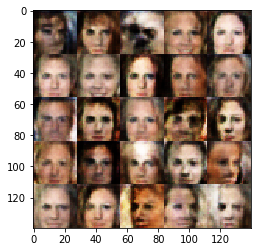

Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.9250
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.9816
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.8234
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.6498


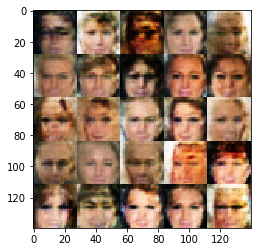

Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 2.0765
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.4289
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.5151
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 1.7597


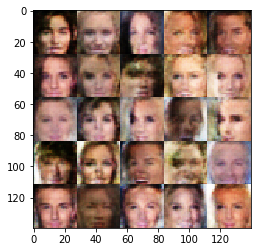

Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.6627
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 2.3074
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 2.5534


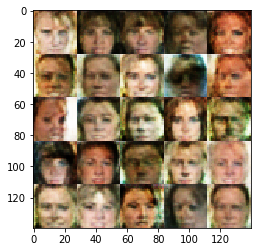

Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 2.3046
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 2.0110
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 2.0846
Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.5501
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 3.4075
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 1.5297
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.6424


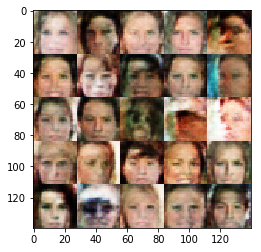

Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.1267
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.5962
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 2.1988
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 1.2207
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.9505
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.9213
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 2.9334


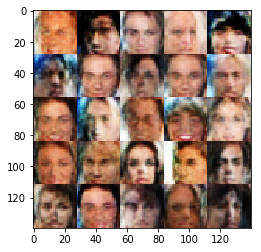

Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.4133
Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 2.9654
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.5494
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.9693


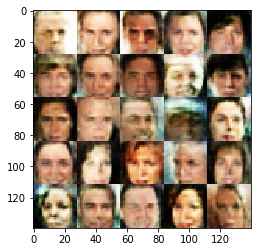

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 0.6102... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.5270
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 2.3590


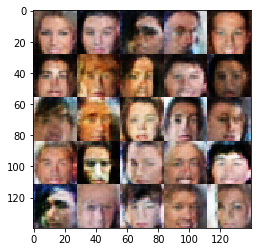

Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 2.5809
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.4454
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 2.5040
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.9925


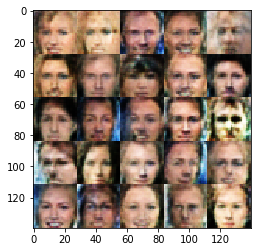

Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 2.1916
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 0.3822


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [24]:
print("###############################################################################")
print("oye, training is done.")
print("###############################################################################")

###############################################################################
oye, training is done.
###############################################################################


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.